In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

### You may need to clone the latest version of [pyathena](https://github.com/changgoo/pyathena)

In [2]:
from pyathena import dump_zprof

In [3]:
# Here, I define a data_container class to set 
# vtk file path, parameter file path, and history file path, 
# and read parameter and history.
# 
# Basically I assume the path to the vtk/par/hst files looks like
#
#    /base/pdir/pid/id0/pid.????.vtk
#    /base/pdir/pid/pid.par
#    /base/pdir/pid/hst/pid.hst
#
# You can modify the path appropriately
#

base='/tigress/changgoo/'
pid='RPS_8pc_ICM1_newacc'
pdir=pid + '/'
dc=dump_zprof.data_container(pid,base=base,pdir=pdir)

Reading a history file:/tigress/changgoo/RPS_8pc_ICM1_newacc//hst/RPS_8pc_ICM1_newacc.hst.p


# Recalculate z-profiles from vtk

Below (`dump_zprof_one`) is a function to calculate horizontally-integrated vertical-profiles from a vtk dump. The result will be saved to (`/base/pdir/pid/zprof_icm/pid.????.phase-icm.zprof`). The same calculate is done to create `zprof`, but now it creates additional zprof for ICM, multplying by `f_icm` (`specific_scalar4`). For example, density profile is defined by
$$ \rho(k) \equiv \sum_{i,j} \rho(i,j,k) \Delta x \Delta y $$
$$ \rho_{\rm ICM}(k) \equiv \sum_{i,j} \rho(i,j,k)f_{\rm ICM}(i,j,k) \Delta x \Delta y $$
In practice, we also separate it into 5 thermal phases.

In [4]:
zpdf,zpdf_icm=dump_zprof.dump_zprof_one(dc.vtkfiles[-1],dc,icm_field='s4')

Reading:  /tigress/changgoo/RPS_8pc_ICM1_newacc/id0/RPS_8pc_ICM1_newacc.0498.vtk
Calculating zprof...
0/14 1/14 2/14 3/14 4/14 5/14 6/14 7/14 8/14 9/14 10/14 11/14 12/14 13/14 
Writing at /tigress/changgoo/RPS_8pc_ICM1_newacc/zprof_icm: 
phase1 phase2 phase3 phase4 phase5 

### sanity check

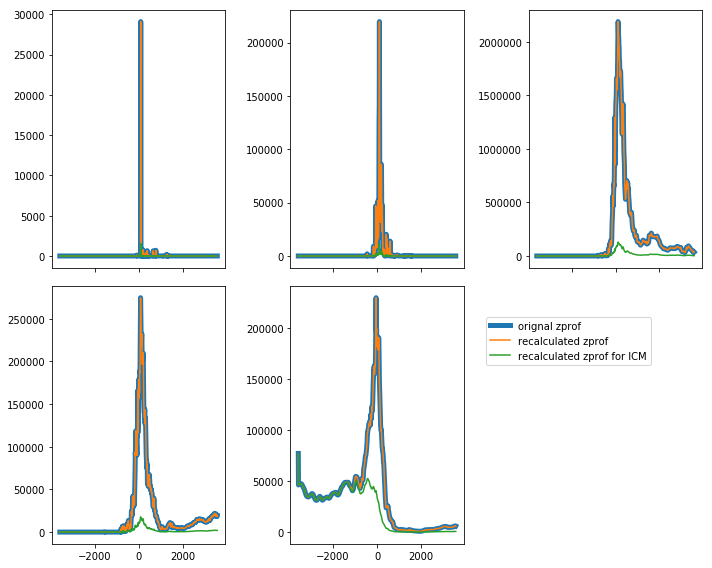

In [8]:
import pyathena.preprocessing as pre
import matplotlib.pyplot as plt

fig,axes=plt.subplots(2,3,figsize=(10,8),sharex=True)
field='pFzd'
plist=['phase1','phase2','phase3','phase4','phase5']
for ph,ax in zip(plist,axes.flat):
    zp_orig,time=pre.read_zprof_one(base+pdir+'zprof/'+pid+'.0498.{}.zprof'.format(ph))
    zp_recal,time=pre.read_zprof_one(base+pdir+'zprof_icm/'+pid+'.0498.{}.zprof'.format(ph)) # this is for the sanity check
    zp_icm,time=pre.read_zprof_one(base+pdir+'zprof_icm/'+pid+'.0498.{}-icm.zprof'.format(ph))

    ax.plot(zp_orig['z'],zp_orig[field],lw=5,label='orignal zprof')
    ax.plot(zp_recal['z'],zp_recal[field],label='recalculated zprof')
    ax.plot(zp_icm['z'],zp_icm[field],label='recalculated zprof for ICM')
axes.flat[-1].axis('off')
plt.tight_layout()
ax.legend(bbox_to_anchor=[1.1,0.9])

### Below is a code to recalculate zprof from all the vtk files

In [ ]:
import os
pid_list=['RPS_8pc_ICM0_newacc','RPS_8pc_ICM1_newacc','RPS_8pc_ICM2_newacc','RPS_8pc_ICM3_newacc','RPS_8pc_ICM4_newacc',
          'RPS_4pc_ICM1_newacc','RPS_4pc_ICM2_newacc']

base='/tigress/changgoo/'

for pid in pid_list:
    pdir=pid + '/'

    outdir='zprof_icm'
    if not os.path.isdir(base+pdir+outdir+'/'): os.mkdir(base+pdir+outdir)
    
    dc=dump_zprof.data_container(pid,base=base,pdir=pdir)
    for f in dc.vtkfiles:
        dump_zprof.dump_zprof_one(f,dc,icm_field='s4',outdir=outdir)